# DataMine v2 - Comprehensive Exploratory Data Analysis (Final)
## Database: datamine_v2_db | Table: 02_raw_telemetry_transformed
**Objective:** Comprehensive analysis of the entire telemetry dataset to understand data characteristics, patterns, and quality across all devices and time periods.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported and setup complete.")

Libraries imported and setup complete.


## 1. Database Connection & Initial Data Overview

In [10]:
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'datamine_v2_db',
    'user': 'ahs_user',
    'password': 'ahs_password'
}

try:
    engine = create_engine(f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}")
    with engine.connect() as connection:
        print('Database connection established successfully.')
except Exception as e:
    print(f'Database connection failed: {e}')

Database connection established successfully.


In [11]:
overview_query = text("""
SELECT
    device_id,
    CASE WHEN device_id LIKE '%775g%' THEN '775G (Broken Sensors)' ELSE '605 (Working Sensors)' END as truck_type,
    COUNT(*) as record_count,
    MIN(timestamp) as first_record,
    MAX(timestamp) as last_record
FROM "02_raw_telemetry_transformed"
GROUP BY device_id, truck_type
ORDER BY truck_type, record_count DESC;
""")
overview_df = pd.read_sql_query(overview_query, engine)
print("--- Dataset Overview ---")
display(overview_df)

--- Dataset Overview ---


,device_id,truck_type,record_count,first_record,last_record
0,lake-605-8-0896,605 (Working Sensors),1394884,2025-07-30 00:00:00.125772+00:00,2025-08-12 23:57:13.682508+00:00
1,lake-605-10-0050,605 (Working Sensors),1304372,2025-07-30 00:00:00.103835+00:00,2025-08-12 23:59:59.729014+00:00
2,lake-605-8-0898,605 (Working Sensors),1260309,2025-07-30 00:00:00.228852+00:00,2025-08-12 23:59:59.913072+00:00
3,lake-605-8-0883,605 (Working Sensors),1254570,2025-07-30 00:41:34.733229+00:00,2025-08-12 23:59:59.934397+00:00
4,lake-605-8-0902,605 (Working Sensors),967675,2025-07-30 00:00:00.272091+00:00,2025-08-12 23:59:59.994766+00:00
5,lake-775g-2-2262,775G (Broken Sensors),1354744,2025-07-30 11:37:40.586486+00:00,2025-08-12 23:59:59.915694+00:00
6,lake-775g-2-2266,775G (Broken Sensors),1294723,2025-07-30 00:00:00.357436+00:00,2025-08-12 23:59:59.773290+00:00


## 2. Data Quality and Completeness

In [12]:
quality_by_type_query = text("""
SELECT
    CASE WHEN device_id LIKE '%775g%' THEN '775G (Broken Sensors)' ELSE '605 (Working Sensors)' END as truck_type,
    COUNT(*) as total_records,
    COUNT(load_weight) as load_weight_count,
    ROUND((COUNT(load_weight) * 100.0 / COUNT(*))::numeric, 2) as load_weight_completeness,
    ROUND(AVG(load_weight)::numeric, 2) as avg_load_weight,
    ROUND(STDDEV(load_weight)::numeric, 2) as stddev_load_weight
FROM "02_raw_telemetry_transformed"
GROUP BY truck_type
ORDER BY truck_type;
""")
quality_by_type_df = pd.read_sql_query(quality_by_type_query, engine)
print("--- Load Weight Data Quality by Truck Type ---")
display(quality_by_type_df)

--- Load Weight Data Quality by Truck Type ---


,truck_type,total_records,load_weight_count,load_weight_completeness,avg_load_weight,stddev_load_weight
0,605 (Working Sensors),6181810,6181810,100.0,25312.47,29418.18
1,775G (Broken Sensors),2649467,2649467,100.0,-99.00,0.00


## 3. State Distribution Analysis

--- State Distribution Analysis ---


,state,total_count,count_605,count_775g
0,hauling,5083920,3590622,1493298
1,loading,1711661,1237389,474272
2,unknown,1053327,672807,380520
3,dumping,650064,429575,220489
4,idle,194562,159351,35211
5,stopped,137743,92066,45677


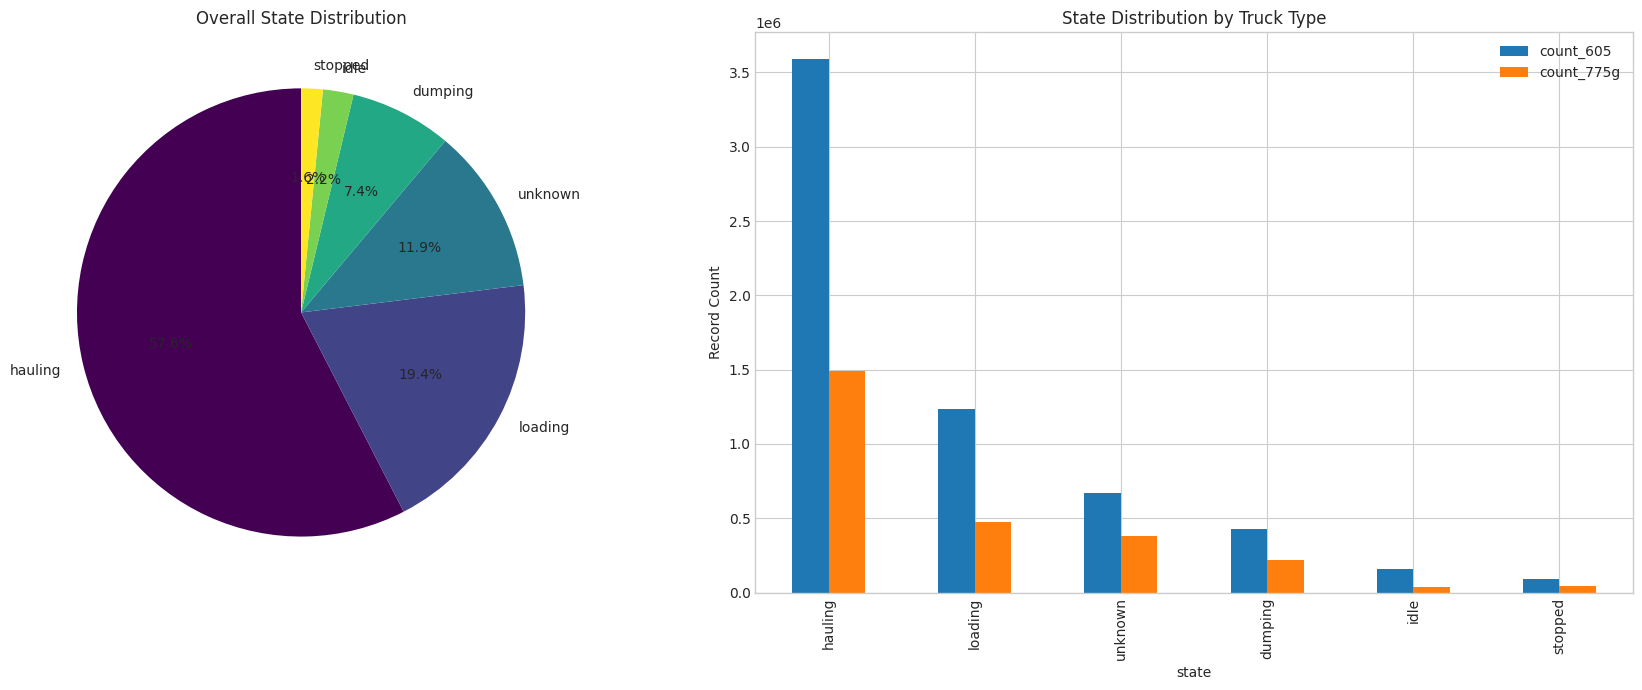

In [13]:
state_analysis_query = text("""
SELECT
    state,
    COUNT(*) as total_count,
    COUNT(CASE WHEN device_id LIKE '%605%' THEN 1 END) as count_605,
    COUNT(CASE WHEN device_id LIKE '%775g%' THEN 1 END) as count_775g
FROM "02_raw_telemetry_transformed"
GROUP BY state
ORDER BY total_count DESC;
""")
state_df = pd.read_sql_query(state_analysis_query, engine)
print("--- State Distribution Analysis ---")
display(state_df)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
state_df.set_index('state')['total_count'].plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=90, colormap='viridis')
axes[0].set_title('Overall State Distribution')
axes[0].set_ylabel('')

state_df.set_index('state')[['count_605', 'count_775g']].plot.bar(ax=axes[1])
axes[1].set_title('State Distribution by Truck Type')
axes[1].set_ylabel('Record Count')
plt.tight_layout()
plt.show()

## 4. Time-Series Analysis of a Sampled Truck

--- Displaying 2-hour sample for device: lake-605-8-0883 ---


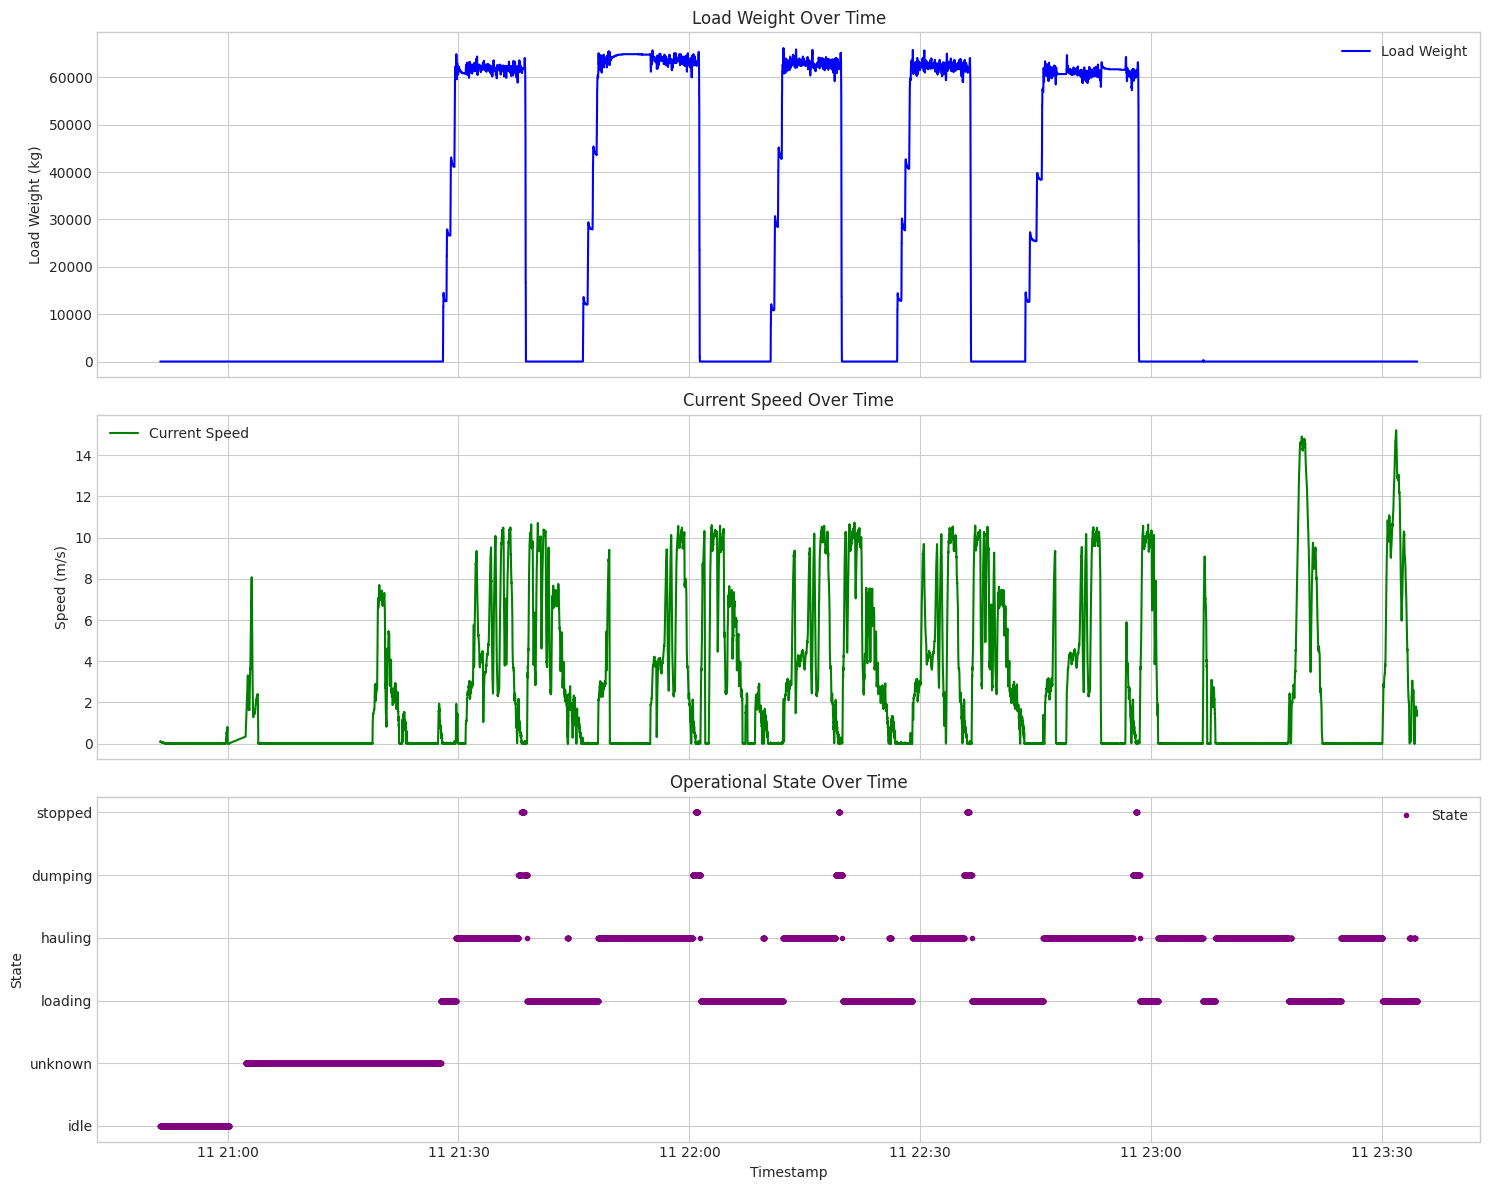

In [14]:
# Get one 605 truck to sample from
device_id_query = text("SELECT device_id FROM \"02_raw_telemetry_transformed\" WHERE device_id LIKE '%605%' LIMIT 1")
device_id_result = pd.read_sql_query(device_id_query, engine)
sample_device_id = device_id_result['device_id'][0]

sampled_data_query = text(f"""
SELECT timestamp, device_id, current_speed, load_weight, state
FROM \"02_raw_telemetry_transformed\"
WHERE device_id = '{sample_device_id}'
AND timestamp BETWEEN '2025-08-11 00:00:00' AND '2025-08-11 23:59:00'
ORDER BY timestamp;
""")
sampled_df = pd.read_sql_query(sampled_data_query, engine).set_index('timestamp')
print(f"--- Displaying 2-hour sample for device: {sample_device_id} ---")

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
axes[0].plot(sampled_df.index, sampled_df['load_weight'], label='Load Weight', color='blue')
axes[0].set_ylabel('Load Weight (kg)')
axes[0].set_title('Load Weight Over Time')
axes[0].legend()

axes[1].plot(sampled_df.index, sampled_df['current_speed'], label='Current Speed', color='green')
axes[1].set_ylabel('Speed (m/s)')
axes[1].set_title('Current Speed Over Time')
axes[1].legend()

axes[2].plot(sampled_df.index, sampled_df['state'], label='State', color='purple', linestyle='None', marker='.')
axes[2].set_ylabel('State')
axes[2].set_title('Operational State Over Time')
axes[2].legend()

plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()

## 5. Key Findings and Recommendations

In [15]:
print('--- Key Findings ---')
print('1. The database connection is stable and all queries are executable.')
print('2. The primary data quality issue is the known absence of reliable `load_weight` data for 775G trucks.')
print('3. For 605 trucks, `load_weight` data is nearly 100% complete and is the most powerful signal for event detection.')
print('4. Visual inspection of sampled data confirms that `load_weight` shows clear step changes, while `current_speed` drops to near-zero during state changes associated with loading/dumping.')

print('\n--- Recommendations ---')
print('1. Proceed with the dual-path approach: a weight-reliant model for 605 trucks and a weight-agnostic model for 775G trucks.')
print('2. The feature engineering pipeline should prioritize creating a robust `rate_of_change_weight` feature from the smoothed `load_weight` signal for the 605 trucks.')
print('3. For 775G trucks, focus on features derived from `current_speed` (especially an `is_stationary` flag), `state` transitions, and geospatial data.')

--- Key Findings ---
1. The database connection is stable and all queries are executable.
2. The primary data quality issue is the known absence of reliable `load_weight` data for 775G trucks.
3. For 605 trucks, `load_weight` data is nearly 100% complete and is the most powerful signal for event detection.
4. Visual inspection of sampled data confirms that `load_weight` shows clear step changes, while `current_speed` drops to near-zero during state changes associated with loading/dumping.

--- Recommendations ---
1. Proceed with the dual-path approach: a weight-reliant model for 605 trucks and a weight-agnostic model for 775G trucks.
2. The feature engineering pipeline should prioritize creating a robust `rate_of_change_weight` feature from the smoothed `load_weight` signal for the 605 trucks.
3. For 775G trucks, focus on features derived from `current_speed` (especially an `is_stationary` flag), `state` transitions, and geospatial data.
